# Wisconsin Autonomous Perception Challenge Spring 2025
### Grant Hohol

### Import necessary libraries

In [86]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

### Load image

In [87]:
image = cv2.imread('red.png')

if image is None:
    print("Error: Image not found!")
    exit()

# Make copy to draw lines later
orig_image = image.copy()

### Output image

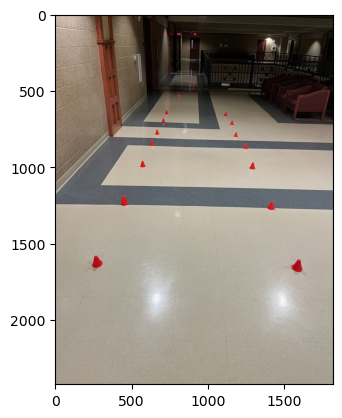

In [88]:
# Convert to RGB to output since cv2 loads in BGR
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.imshow(image_rgb)
plt.show()

### Convert again to HSV so we can isolate orange for thresholding

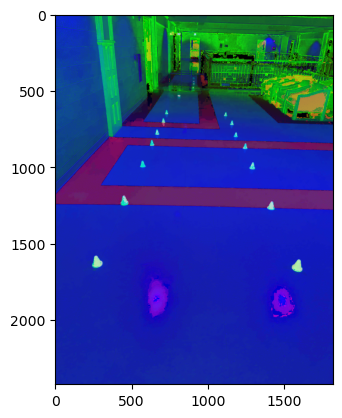

In [89]:
hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

plt.imshow(hsv)
plt.show()

### Thresholding to isolate orange cones

It is difficult to find the correct bounds and this is something I want to learn better techniques for

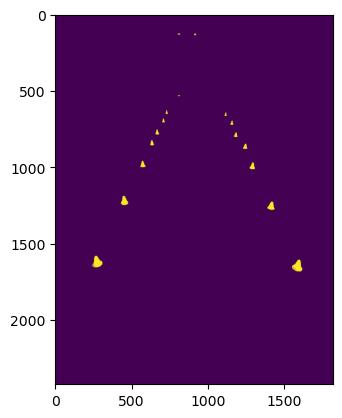

In [90]:
# Define bounds for orange
lower = np.array([0, 160, 160]) # (Hue, Saturation, Value)
upper = np.array([255, 255, 255])

# create mask
mask = cv2.inRange(hsv, lower, upper)

plt.imshow(mask)
plt.show()

### Save mask to check in binary color

In [91]:
cv2.imwrite('mask.png', mask)

True

### Find contours in the cones

In [92]:
# Find contours in the mask
contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Filter out small contours (noise)
min_contour_area = 50 
filtered_contours = [cnt for cnt in contours if cv2.contourArea(cnt) > min_contour_area]

cv2.drawContours(image, filtered_contours, -1, (0, 255, 0), 2)
cv2.imwrite('contours.png', image)



True

In [93]:
print(len(filtered_contours))

16


It is detecting some things that are not cones but we will see how that affects our lines

### Computer centroid of the contours

In [94]:
centroids = [] # list of centroids of cones

for cont in filtered_contours:
    M = cv2.moments(cont) # returns dictionary of moments
    if M['m00'] != 0: # assure area of contour is not 0

        # compute centroids x and y pixel values
        # I understand that this is how you compute it and that m00 is area, but I would like to learn more about
        # why this is the case and further understanding first order spatial moments
        cx = int(M['m10'] / M['m00'])
        cy = int(M['m01'] / M['m00'])
        centroids.append([cx, cy])

print(f"Centroids: \n{centroids}")

Centroids: 
[[1584, 1650], [275, 1624], [1412, 1257], [453, 1224], [1289, 996], [573, 984], [1242, 867], [633, 844], [1180, 791], [667, 774], [1155, 713], [708, 698], [1114, 656], [729, 644], [914, 132], [808, 131]]


Remove the last two centroids as we know they are not cones

In [95]:
centroids = centroids[0:14]

### Cluster the centroids into two left and right groups so we can create two lines

In [96]:
centroids_np = np.array(centroids, dtype=np.float32)

criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
_, labels, centers = cv2.kmeans(centroids_np, 2, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)


labels

array([[1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0]], dtype=int32)

Split up evenly between 1 and 0 is a good sign

In [97]:
# split into left and right clusters
left_cluster = centroids_np[labels.flatten() == 0]
right_cluster = centroids_np[labels.flatten() == 1]

print(f"Left Cluster: \n{left_cluster}\n\nRight Cluster: \n{right_cluster}")

Left Cluster: 
[[ 275. 1624.]
 [ 453. 1224.]
 [ 573.  984.]
 [ 633.  844.]
 [ 667.  774.]
 [ 708.  698.]
 [ 729.  644.]]

Right Cluster: 
[[1584. 1650.]
 [1412. 1257.]
 [1289.  996.]
 [1242.  867.]
 [1180.  791.]
 [1155.  713.]
 [1114.  656.]]


We can see from the points that this is correct because the right cluster has all higher x-values

### Fit a line through each cluster

In [98]:
def fit_line(cluster, image_height):
    line = cv2.fitLine(cluster, cv2.DIST_L2, 0, 0.01, 0.01)
    vx, vy, x0, y0, = line[0], line[1], line[2], line[3]

    # calcuate two points to draw linear line
    y_min = 0
    y_max = image_height
    slope = vx/vy # rise over run
    x_min = int(x0 + (y_min - y0) * (slope))
    x_max = int(x0 + (y_max - y0) * (slope))

    return (x_min, y_min), (x_max, y_max)

height = orig_image.shape[0]

# get two end points for each of the two lines
left_line_end_pts = fit_line(left_cluster, height) 
right_line_end_pts = fit_line(right_cluster, height)

C:\Users\grant\AppData\Local\Temp\ipykernel_1288\1619626383.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x_min = int(x0 + (y_min - y0) * (slope))
C:\Users\grant\AppData\Local\Temp\ipykernel_1288\1619626383.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x_max = int(x0 + (y_max - y0) * (slope))


### Draw lines and save image

In [99]:
cv2.line(orig_image, left_line_end_pts[0], left_line_end_pts[1], (0, 0, 255), 3)
cv2.line(orig_image, right_line_end_pts[0], right_line_end_pts[1], (0, 0, 255), 3)

cv2.imwrite('answer.png', orig_image)


True